## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

Worked with Rajesh Sathpathy and Anusha Battu

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  242k  100  242k    0     0  2605k      0 --:--:-- --:--:-- --:--:-- 2605k


The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

mkdir: cannot create directory ‘us-congress-tweets’: File exists
--2022-03-07 00:11:20--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.77.28
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.77.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 00:11:20 (121 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 00:11:20--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 52.217.77.28
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|52.217.77.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
conf = SparkConf().set("spark.ui.port", "4050")

# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [8]:
# your code here for unique users
user_mentions = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True)
user_mentions.show()
from pyspark.sql.functions import col
uniqueEndUsers = tweets.filter(col("user_id").isNotNull()).select('user_id').distinct().count()
print(uniqueEndUsers, 'is the unique end users')

+------------------+------------------+-----+
|               src|               dst|count|
+------------------+------------------+-----+
|917194889275699201|        1249982359|    1|
|917570582555779072|         251918778|    1|
|         633674091|         432895323|   48|
|913222391416934402|         432895323|  261|
|         217574712|          47203904|    1|
|931278145679847424|         320757267|    1|
|897332217646522368|          92186819|    8|
|        2308265716|          18061669|    4|
|822826488500088832|        1249982359|  132|
|728645535566008320|958064770019741696|    1|
|827323185058033665|          14247236|   11|
|          36566383|826629809954553856|    2|
|913125313172918272|         432895323|   90|
|860643294367318016|         432895323|   52|
|866790059802079234|         432895323|  148|
|888055635828502530|          16056306|    2|
|        3141820397|         112006107|    1|
|836681162638532608|         262756641|    1|
|         157952243|         10239

b) How many times is the user **GOPLeader** mentioned?


In [9]:
# code here
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col

name_of_mentioned_user = 'GOPLeader'

id_of_user_mentioned = congress_members.filter(congress_members['screen_name'] == name_of_mentioned_user).select('userid').first()['userid']
count_of_mentionedUsers = tweets.filter(array_contains(col('entities.user_mentions.id'), float(id_of_user_mentioned))).count()
print('User with the name', name_of_mentioned_user, 'is mentioned',count_of_mentionedUsers, 'number of times, by counting a tweet once')

count_of_mentionedUsers_rep = tweets.select(F.explode(tweets.entities.user_mentions.screen_name).alias("user_mention")).filter(F.col("user_mention") == name_of_mentioned_user).count()
print('User with the name', name_of_mentioned_user, 'is mentioned',count_of_mentionedUsers_rep, 'number of times, by counting the total of over all tweets')

id_of_mentionedUsers = congress_members.filter(congress_members['screen_name'] == name_of_mentioned_user).select('userid').first()['userid']
print('Here the user', name_of_mentioned_user, 'is assigned with the id', id_of_mentionedUsers)

user_mention_freq = user_mentions.filter(user_mentions['dst'] == id_of_user_mentioned).select('count').agg({'count':'sum'}).first()['sum(count)']
print(name_of_mentioned_user, 'is mentioned -->', user_mention_freq, 'times totally in over all tweets')

User with the name GOPLeader is mentioned 4728 number of times, by counting a tweet once
User with the name GOPLeader is mentioned 4761 number of times, by counting the total of over all tweets
Here the user GOPLeader is assigned with the id 19739126
GOPLeader is mentioned --> 52723.0 times totally in over all tweets


c) Now find the top-5 most mentioned members of Congress.

In [10]:
# code here
from pyspark.sql.functions import col, array_contains
from pyspark.sql.functions import explode
explodedUsers = tweets.select(explode(tweets.entities.user_mentions.id).alias('user_mentions_id'))
explodedUsersDataFrameCount = explodedUsers.groupby('user_mentions_id').agg({'user_mentions_id': 'count'}).select(col('user_mentions_id'), col('count(user_mentions_id)').alias('mention_freq'))
print('Table to represent top-5 most mentioned members of Congress:')                                                          
explodedUsersDataFrameCount.join(congress_members, congress_members.userid == explodedUsersDataFrameCount.user_mentions_id, 'inner').sort(col('mention_freq').desc()).select('screen_name', 'mention_freq').limit(5).show()

Table to represent top-5 most mentioned members of Congress:
+---------------+------------+
|    screen_name|mention_freq|
+---------------+------------+
|    NancyPelosi|       16135|
|   senatemajldr|       15021|
|LindseyGrahamSC|       14412|
|     SenSchumer|       13738|
|  RepAdamSchiff|       13288|
+---------------+------------+



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [11]:
# code here
from pyspark.sql.functions import explode, month
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col, concat, lit

print('Table to represent top-5 most mentioned members across all the. users in dataset')

monthlyTweets= tweets.withColumn('month', month(tweets.created_at))
monthlyTweets_exploded = monthlyTweets.select('month', explode(tweets.entities.user_mentions.screen_name).alias('user_mentions_screen_name'))
monthlyTweets_explodedMonth = monthlyTweets_exploded.groupby('month', 'user_mentions_screen_name').agg({'user_mentions_screen_name': 'count'}).select('*', col('count(user_mentions_screen_name)').alias('mention_freq')).select('user_mentions_screen_name', 'mention_freq', 'month')

window_month = Window.partitionBy(monthlyTweets_explodedMonth['month']).orderBy(monthlyTweets_explodedMonth['mention_freq'].desc())

monthlyTweets_explodedMonth_top5 = monthlyTweets_explodedMonth.select('*', rank().over(window_month).alias('rank')).filter(col('rank') <= 5)

monthlyTweets_explodedMonth_top5.show(60)

Table to represent top-5 most mentioned members across all the. users in dataset
+-------------------------+------------+-----+----+
|user_mentions_screen_name|mention_freq|month|rank|
+-------------------------+------------+-----+----+
|          realDonaldTrump|        4154|    1|   1|
|            SpeakerPelosi|        3318|    1|   2|
|               SenSchumer|        2797|    1|   3|
|             senatemajldr|        2577|    1|   4|
|          LindseyGrahamSC|        1818|    1|   5|
|            RepAdamSchiff|        2301|    3|   1|
|          realDonaldTrump|        1906|    3|   2|
|          LindseyGrahamSC|        1570|    3|   3|
|               marcorubio|        1494|    3|   4|
|            SpeakerPelosi|        1120|    3|   5|
|          LindseyGrahamSC|        1945|    5|   1|
|          realDonaldTrump|        1812|    5|   2|
|            SpeakerPelosi|        1481|    5|   3|
|            RepAdamSchiff|        1459|    5|   4|
|              justinamash|        

e) Do you notice anything interesting in your monthly analysis?

From the month and user_mentions_screen_name columns we can notice that "realDonaldTrump" user is occuring in almost all the months. When we consider the rank of the user "realDonaldTrump" we can observe that apart from the month 10 where its rank is 4, rest all the months its rank is either 1 or 2.

## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [12]:
# your network construction code here
from graphframes import *
mensions_of_users = spark.read.csv("us-congress-tweets/user_mentions.csv", header = True)
vertices = (mensions_of_users.select("src").distinct()).union(mensions_of_users.select("dst").distinct()).distinct().select(col('src').alias('id'))
edges = mensions_of_users
network = GraphFrame(vertices, edges)
print('Vertices displayed using the alias id')
network.vertices.show()
print('Edges her are showing the number of users mentioned')
network.edges.show()

Vertices displayed using the alias id
+-------------------+
|                 id|
+-------------------+
|          508996900|
|           53589935|
|           30191308|
|         1325721486|
|1025446910218227712|
|         1434240264|
|          985456944|
|1022001889423044610|
| 885326729778253824|
|         4356169936|
|          779204136|
|         1534791056|
| 918883537671122945|
|          154197726|
|         1077650310|
|          196429298|
| 829701100001492994|
|           22372268|
|           99194817|
| 958549180355551232|
+-------------------+
only showing top 20 rows

Edges her are showing the number of users mentioned
+------------------+------------------+-----+
|               src|               dst|count|
+------------------+------------------+-----+
|917194889275699201|        1249982359|    1|
|917570582555779072|         251918778|    1|
|         633674091|         432895323|   48|
|913222391416934402|         432895323|  261|
|         217574712|          4720

How many vertices are there in your network? And how many edges?

In [13]:
# your code
print('The total number of vertices from the above network is ->', vertices.count())
print('The total number of edges from the above network is ->', edges.count())

The total number of vertices from the above network is -> 1133350
The total number of edges from the above network is -> 2064872


Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [14]:
# your PageRank code here (should be pretty short since you're just calling a function)
output = network.pageRank(resetProbability=0.15, maxIter=5)
output

GraphFrame(v:[id: string, pagerank: double], e:[src: string, dst: string ... 2 more fields])

In [15]:
print('pageRanks with respect to their corresponding vertices')
output.vertices.select("id", "pagerank").show()
print('weighted graph network')
output.edges.select("src", "dst", "weight").show()

pageRanks with respect to their corresponding vertices
+-------------------+-------------------+
|                 id|           pagerank|
+-------------------+-------------------+
|1000463993499156481|  0.370078375544821|
|1000785956298018817|  0.370078375544821|
|1001877127115915264|0.49522583964215494|
|1001901894720077824|  0.370078375544821|
|1001918958851710976|  0.370078375544821|
|1002162546978250752|  0.370078375544821|
|1002338860162936832| 1.2670050965419668|
|          100414318|  0.370078375544821|
|1004461220013989888|  0.370078375544821|
|1004865478274244610|0.48186169636776066|
|         1005081223|  0.370078375544821|
|1005181791336984576|  0.370078375544821|
|         1005243704|  0.370078375544821|
|1005412271437369344|  0.370078375544821|
|1005586535436226561|  0.370078375544821|
|1006046436272713728|  0.370078375544821|
|1006268755058577408|  0.370078375544821|
|1006942052104527872|  0.370078375544821|
|1006962721387147264|  0.370078375544821|
|         1007942148|

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [29]:
# Top 10 accounts 
listOfTop_10Accounts = output.vertices.select("id", "pagerank").sort(F.col("pagerank").desc()).limit(10)
listOfTop_10Accounts.join(congress_members, congress_members.userid == listOfTop_10Accounts.id, 'left').select(col('userid'), col('screen_name').alias('congress_user_mentioned'), col('pagerank')).show()

+----------+-----------------------+-----------------+
|    userid|congress_user_mentioned|         pagerank|
+----------+-----------------------+-----------------+
| 240393970|          RepJeffDuncan|7036.967000240482|
|      null|                   null|6701.685539517161|
|      null|                   null|6284.148813341785|
|      null|                   null|5981.435708340409|
|1249982359|           senatemajldr|5587.588320042423|
|  15764644|            NancyPelosi|5061.313584770873|
| 242555999|          SenWhitehouse|4998.188411171005|
|  15808765|             CoryBooker|4698.204423833516|
|  29442313|             SenSanders|4406.403704515815|
|  17494010|             SenSchumer|4387.808250973902|
+----------+-----------------------+-----------------+



What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

After referring the hint URL, we can get observe the following regarding the second, third, and fourth most active users are not congress members.

* The president of United States Donald Trump is the third user. Archived - Although the president is not a member of congress, he plays a significant role which is understandable.
* for the user id: 25073877 we are getting 404 user not found error- The user may have removed their Twitter handle and is no longer available.
* CelebrateMemphis who is the fourth user- I'm not sure why park is being mentioned instead.

## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


In [39]:
from pyspark.sql.functions import size,col
print('List of topmost 10 people who reached more people:')
tweets.select(col('user.screen_name').alias('screen_name'), size(col('entities.user_mentions.id')).alias('user_mentions_count')).groupby('screen_name').agg({'user_mentions_count': 'sum'}).select(col('screen_name'),col('sum(user_mentions_count)').alias('tot_user_mentions_count')).sort(col('tot_user_mentions_count').desc()).show(10)
print("Motivation: Here I wanted to know the users with highesh reach i.e., who mentioned a lot of other people in their tweets")

List of topmost 10 people who reached more people:
+---------------+-----------------------+
|    screen_name|tot_user_mentions_count|
+---------------+-----------------------+
|      gott_arun|                    695|
| alllibertynews|                    657|
|     wefishhm70|                    605|
|  openletterbot|                    597|
|    MikeWebbNow|                    509|
| Unitedminingal|                    293|
|PatriciaHammes2|                    242|
|     rajbinder7|                    236|
|     NebraskaP5|                    234|
|   Mikeymgm1701|                    231|
+---------------+-----------------------+
only showing top 10 rows

Motivation: Here I wanted to know the users with highesh reach i.e., who mentioned a lot of other people in their tweets


## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

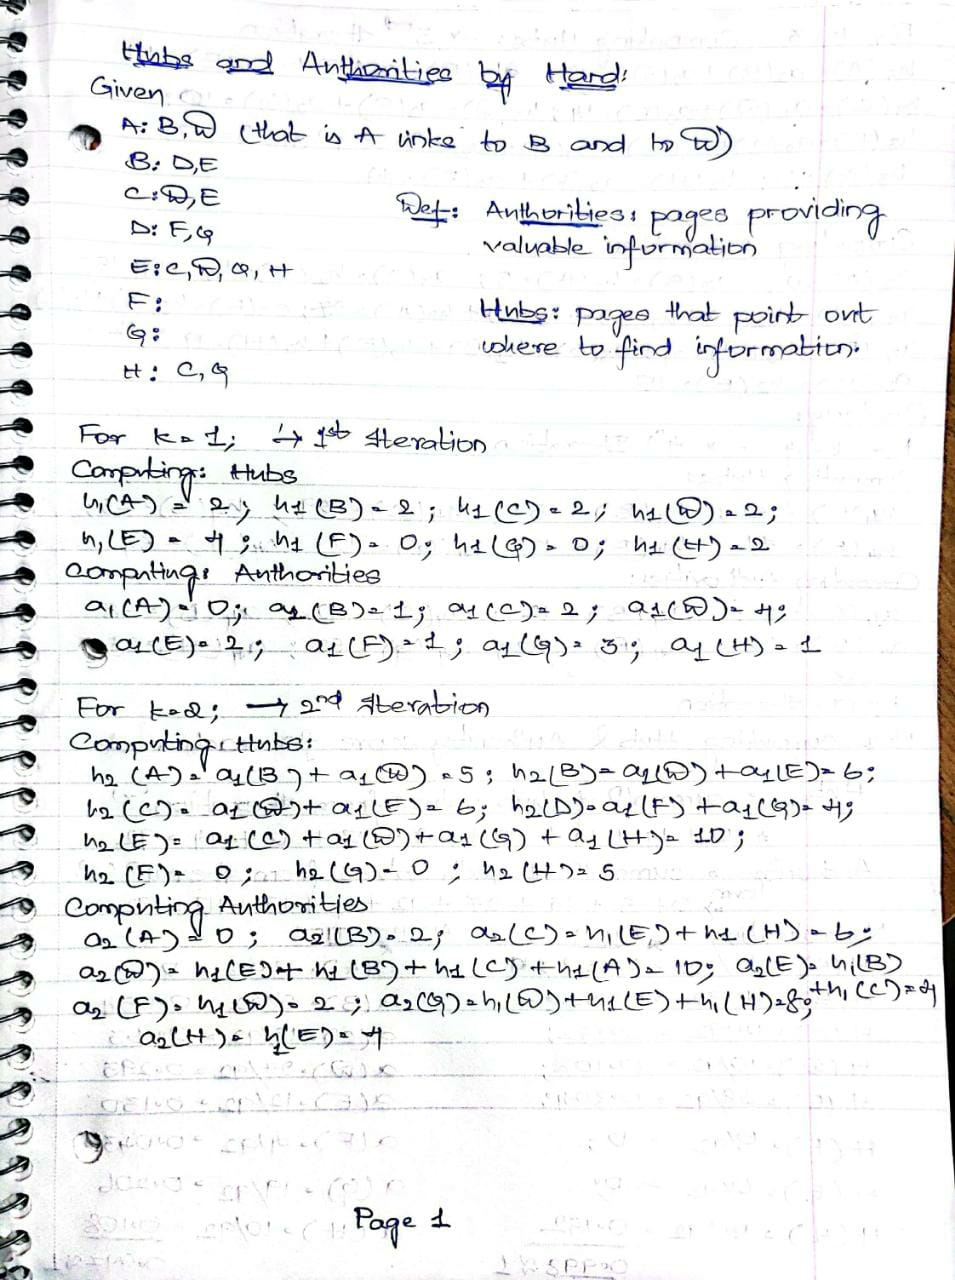*show your steps here*

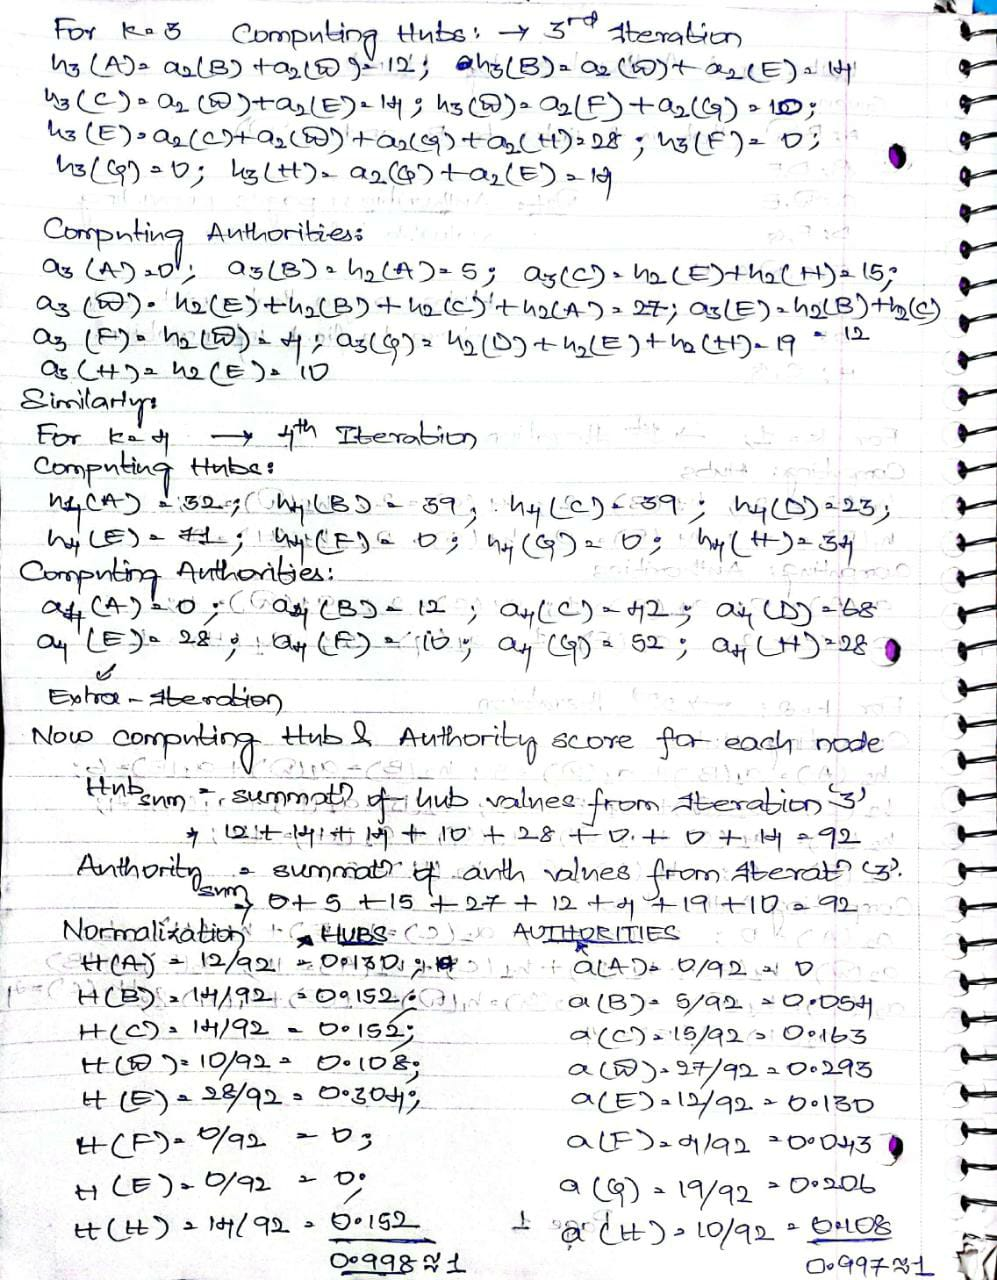

## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 


### ***Exercise 3.1.2 (Page 78)***

In [17]:
print("Let us assume there are 2 sets named 'X' and 'Y' , for 2 sets the 'Jaccard Bag Similarity' is given by the formula as follows:")
print("J(X, Y) = {sizeOf(X intersection Y)} divided by {sizeOf(X) + sizeOf(Y)}")
print("From the question let us consider the given three sets to be 'X', 'Y' and 'Z'")
print("From this we can form three pairs of sets such as set {X, Y} , set {X, Z}, and set {Y, Z}.")
print("Let X = {1, 1, 1, 2}\nLet Y = {1, 1, 2, 2, 3}\nLet Z = {1, 2, 3, 4}")
print()
print("Now we will calculate Jaccard bag similarity for each pair of sets from the above as follows:")
print()
print("CASE A:")
print("For pair X = {1, 1, 1, 2} and Y = {1, 1, 2, 2, 3}")
print("J(X, Y) = {sizeOf(X intersection Y)} divided by {sizeOf(X) + sizeOf(Y)}")
print("{X intersection Y} = {1, 1, 2}\n{X union Y } = {1, 1, 1, 2, 1, 1, 2, 2, 3}")
print("sizeOf{X intersection Y} = |1, 1, 2| = 3\n{sizeOf(X) + sizeOf(Y)} = |1, 1, 1, 2, 1, 1, 2, 2, 3| = 9")
print("From the formula above J(X, Y) = 3/9 = 0.33")
print()
print("CASE B:")
print("For pair X = {1, 1, 1, 2} and Z = {1, 2, 3, 4}")
print("J(X, Z) = {sizeOf(X intersection Z)} divided by {sizeOf(X) + sizeOf(Z)}")
print("{X intersection Z} = {1, 2}\n{X union Z } = {1, 1, 1, 2, 1, 2, 3, 4}")
print("sizeOf{X intersection Z} = |1, 2| = 2\n{sizeOf(X) + sizeOf(Z)} = |1, 1, 1, 2, 1, 2, 3, 4| = 8")
print("From the formula above J(X, Z) = 2/8 = 0.25")
print()
print("CASE C:")
print("For pair Y = {1, 1, 2, 2, 3} and Z = {1, 2, 3, 4}")
print("J(Y, Z) = {sizeOf(Y intersection Z)} divided by {sizeOf(Y) + sizeOf(Z)}")
print("{Y intersection Z} = {1, 2, 3}\n{Y union Z } = {1, 1, 2, 2, 3, 1, 2, 3, 4}")
print("sizeOf{Y intersection Z} = |1, 2, 3| = 3\n{sizeOf(Y) + sizeOf(Z)} = |1, 1, 2, 2, 3, 1, 2, 3, 4| = 9")
print("From the formula above J(Y, Z) = 3/9 = 0.33")

Let us assume there are 2 sets named 'X' and 'Y' , for 2 sets the 'Jaccard Bag Similarity' is given by the formula as follows:
J(X, Y) = {sizeOf(X intersection Y)} divided by {sizeOf(X) + sizeOf(Y)}
From the question let us consider the given three sets to be 'X', 'Y' and 'Z'
From this we can form three pairs of sets such as set {X, Y} , set {X, Z}, and set {Y, Z}.
Let X = {1, 1, 1, 2}
Let Y = {1, 1, 2, 2, 3}
Let Z = {1, 2, 3, 4}

Now we will calculate Jaccard bag similarity for each pair of sets from the above as follows:

CASE A:
For pair X = {1, 1, 1, 2} and Y = {1, 1, 2, 2, 3}
J(X, Y) = {sizeOf(X intersection Y)} divided by {sizeOf(X) + sizeOf(Y)}
{X intersection Y} = {1, 1, 2}
{X union Y } = {1, 1, 1, 2, 1, 1, 2, 2, 3}
sizeOf{X intersection Y} = |1, 1, 2| = 3
{sizeOf(X) + sizeOf(Y)} = |1, 1, 1, 2, 1, 1, 2, 2, 3| = 9
From the formula above J(X, Y) = 3/9 = 0.33

CASE B:
For pair X = {1, 1, 1, 2} and Z = {1, 2, 3, 4}
J(X, Z) = {sizeOf(X intersection Z)} divided by {sizeOf(X) + sizeOf

### ***Exercise 3.2.2 (Page 81)***

In [18]:
print("We have to print all the shingles from the first sentence of the section 3.2 following\nthe stop-word-based shingles concept depicted in the section 3.2.4")
print()
print("Below is the first sentence from the section 3.2:")
print()
print("The most effective way to represent documents as sets, for the purpose of identifying lexically\nsimilar documents is to construct from the document the set of short strings that appear within it.")
print()
print("Below is the condition given:")
print("Consider the stop words to be all the words of three or fewer letters")
print()
print("*Concept for stop-word-based shingles --> the stop-word should be followed by next two words from the statement.")
print()
print("List of stop-words with letters <= 3 in the above statement are as follows:")
print("--> the, to, as, for, of, is, it")
print()
print("List of stop-word-based 3 word-Shingles:")
print("1.  The most effective")
print("2.  way to represent")
print("3.  to represent documents")
print("4.  as sets for")
print("5.  for the purpose")
print("6.  the purpose of")
print("7.  of identifying lexically")
print("8.  is to construct")
print("9.  to construct from")
print("10. the document the")
print("11. the set of")
print("12. set of short")
print("13. of short strings")
print()
print("NOTE: Even though 'it' here is a stop-word-count belonging to the first statement the following 2 words are occuring\nin the next statement hence it is not considered to be the shinglee of the first statements ")

We have to print all the shingles from the first sentence of the section 3.2 following
the stop-word-based shingles concept depicted in the section 3.2.4

Below is the first sentence from the section 3.2:

The most effective way to represent documents as sets, for the purpose of identifying lexically
similar documents is to construct from the document the set of short strings that appear within it.

Below is the condition given:
Consider the stop words to be all the words of three or fewer letters

*Concept for stop-word-based shingles --> the stop-word should be followed by next two words from the statement.

List of stop-words with letters <= 3 in the above statement are as follows:
--> the, to, as, for, of, is, it

List of stop-word-based 3 word-Shingles:
1.  The most effective
2.  way to represent
3.  to represent documents
4.  as sets for
5.  for the purpose
6.  the purpose of
7.  of identifying lexically
8.  is to construct
9.  to construct from
10. the document the
11. the set o

### ***Exercise 3.3.3 (Page 90)***

`**Computing the minhash signature for each column for the given hash functions **`

`h1(x) = 2x + 1 sizeOf 6`

`h2(x) = 3x + 2 sizeOf 6`

`h3(x) = 5x + 2 sizeOf 6.`

In [19]:
from tabulate import tabulate
print("Given matrix for the 3.3.3 problem is as follows:")
table = [['Element', 'S1', 'S2', 'S3', 'S4'], ['0', '0', '1', '0', '1'], ['1', '0', '1', '0', '0'], ['2', '1', '0', '0', '1'], ['3', '0', '0', '1', '0'], ['4', '0', '0', '1', '1'], ['5', '1', '0', '0', '0']]
print(tabulate(table))

Given matrix for the 3.3.3 problem is as follows:
-------  --  --  --  --
Element  S1  S2  S3  S4
0        0   1   0   1
1        0   1   0   0
2        1   0   0   1
3        0   0   1   0
4        0   0   1   1
5        1   0   0   0
-------  --  --  --  --


### **PART A**

In [20]:
from tabulate import tabulate
print("minhash signature matrix:")
table = [['Element(x)', 'S1', 'S2', 'S3', 'S4', '2x + 1 sizeOf 6', '3x + 2 sizeOf 6', '5x + 2 sizeOf 6'], ['0', '0', '1', '0', '1', '1', '2', '2'], ['1', '0', '1', '0', '0', '3', '5', '1'], ['2', '1', '0', '0', '1', '5', '2', '0'], ['3', '0', '0', '1', '0', '1', '5', '5'], ['4', '0', '0', '1', '1', '3', '2', '4'], ['5', '1', '0', '0', '0', '5', '5', '3']]
print(tabulate(table))
print("Here the values in the columns of hash function was calculated by substituting the x value in the corresponding function")
print("For example let us consider the Element x = 2 i.e., row 2 in the given table")
print("Now substituting the x in hash function 2x + 1 sizeOf 6 will give us (2 * 2 + 1)sizeOf 6 --> 5 sizeOf 6 --> which gives us 5 as remainder")

minhash signature matrix:
----------  --  --  --  --  ---------------  ---------------  ---------------
Element(x)  S1  S2  S3  S4  2x + 1 sizeOf 6  3x + 2 sizeOf 6  5x + 2 sizeOf 6
0           0   1   0   1   1                2                2
1           0   1   0   0   3                5                1
2           1   0   0   1   5                2                0
3           0   0   1   0   1                5                5
4           0   0   1   1   3                2                4
5           1   0   0   0   5                5                3
----------  --  --  --  --  ---------------  ---------------  ---------------
Here the values in the columns of hash function was calculated by substituting the x value in the corresponding function
For example let us consider the Element x = 2 i.e., row 2 in the given table
Now substituting the x in hash function 2x + 1 sizeOf 6 will give us (2 * 2 + 1)sizeOf 6 --> 5 sizeOf 6 --> which gives us 5 as remainder


In [21]:
from tabulate import tabulate
print("Now computing minhash signature for each column")
print()
print("Initially the minhash table has infinity by default in all the columns as shown below:")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(x)', 'infy', 'infy', 'infy', 'infy'], ['h2(x)', 'infy', 'infy', 'infy', 'infy'], ['h3(x)', 'infy', 'infy', 'infy', 'infy']]
print(tabulate(table))
print()
print()
print("NOTE: Here the update follows 2 rules as follows:")
print("Rule 1: From the minhash signature matrix consider the columns which has 1 in it and update only those columns")
print("Rule 2: Once we get the columns that have to be updated, compare the element in default minhash signature table with that of the corresponding \nhash function, if the element is less when compared to the present minhash signature table then and only then update the value")
print()
print("Update the columns in the above default signature table for h1(0), h2(0), h3(0)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(0)', 'infy', '1', 'infy', '1'], ['h2(0)', 'infy', '2', 'infy', '2'], ['h3(0)', 'infy', '2', 'infy', '2']]
print(tabulate(table))
print()
print("Update the columns in the above default signature table for h1(1), h2(1), h3(1)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(1)', 'infy', '1', 'infy', '1'], ['h2(1)', 'infy', '2', 'infy', '2'], ['h3(1)', 'infy', '1', 'infy', '2']]
print(tabulate(table))
print()
print("Update the columns in the above default signature table for h1(2), h2(2), h3(2)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(2)', '5', '1', 'infy', '1'], ['h2(2)', '2', '2', 'infy', '2'], ['h3(2)', '0', '1', 'infy', '0']]
print(tabulate(table))
print()
print("Update the columns in the above default signature table for h1(3), h2(3), h3(3)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(3)', '5', '1', '1', '1'], ['h2(3)', '2', '2', '5', '2'], ['h3(3)', '0', '1', '5', '0']]
print(tabulate(table))
print()
print("Update the columns in the above default signature table for h1(4), h2(4), h3(4)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(4)', '5', '1', '1', '1'], ['h2(4)', '2', '2', '2', '2'], ['h3(4)', '0', '1', '4', '0']]
print(tabulate(table))
print()
print("Update the columns in the above default signature table for h1(5), h2(5), h3(5)")
table = [['', 'S1', 'S2', 'S3', 'S4'], ['h1(5)', '5', '1', '1', '1'], ['h2(5)', '2', '2', '2', '2'], ['h3(5)', '0', '1', '4', '0']]
print(tabulate(table))
print()


Now computing minhash signature for each column

Initially the minhash table has infinity by default in all the columns as shown below:
-----  ----  ----  ----  ----
       S1    S2    S3    S4
h1(x)  infy  infy  infy  infy
h2(x)  infy  infy  infy  infy
h3(x)  infy  infy  infy  infy
-----  ----  ----  ----  ----


NOTE: Here the update follows 2 rules as follows:
Rule 1: From the minhash signature matrix consider the columns which has 1 in it and update only those columns
Rule 2: Once we get the columns that have to be updated, compare the element in default minhash signature table with that of the corresponding 
hash function, if the element is less when compared to the present minhash signature table then and only then update the value

Update the columns in the above default signature table for h1(0), h2(0), h3(0)
-----  ----  --  ----  --
       S1    S2  S3    S4
h1(0)  infy  1   infy  1
h2(0)  infy  2   infy  2
h3(0)  infy  2   infy  2
-----  ----  --  ----  --

Update the column

In [22]:
from tabulate import tabulate
print("The Final Minhash Signature Table is as follows:")
table = [['S1', 'S2', 'S3', 'S4'], ['5', '1', '1', '1'], ['2', '2', '2', '2'], ['0', '1', '4', '0']]
print(tabulate(table))

The Final Minhash Signature Table is as follows:
--  --  --  --
S1  S2  S3  S4
5   1   1   1
2   2   2   2
0   1   4   0
--  --  --  --


### **PART B**

In [23]:
print("Only the hash function h3(x) is a true permutation in the given problem. From the minhash signature matrix we can notice that,\nthe h3(x) = 5x + 2 sizeOf 6 has no repeated values in the column of permutation.")

Only the hash function h3(x) is a true permutation in the given problem. From the minhash signature matrix we can notice that,
the h3(x) = 5x + 2 sizeOf 6 has no repeated values in the column of permutation.


### **PART C**

In [24]:
from tabulate import tabulate
print("Here we have to construct a table for estimated Jaccard similarities and true Jaccard similarities so has to determine how close one is to another:")
table = [['S1', 'S2', 'S3', 'S4'], ['0', '1', '0', '1'], ['0', '1', '0', '0'], ['1', '0', '0', '1'], ['0', '0', '1', '0'], ['0', '0', '1', '1'], ['1', '0', '0', '0']]
print("GIVEN MATRIX")
print(tabulate(table))
print()
table = [['S1', 'S2', 'S3', 'S4'], ['5', '1', '1', '1'], ['2', '2', '2', '2'], ['0', '1', '4', '0']]
print("SIGNATURE MATRIX")
print(tabulate(table))
table = [['Similarities', '1-2', '1-3', '1-4', '2-3', '2-4', '3-4'], ['col/col', '0', '0', '1/4', '0', '1/4', '1/4'], ['sig/sig', '1/3', '1/3', '2/3', '2/3', '2/3', '2/3']]
print()
print("Computing the relation of similarities between the columns and signatures")
print(tabulate(table))
print("NOTE: Here the similarity has different meanings for both columns and signatures")
print("1. Similarity in the columns signifies the Jaccard Similarity")
print("2. Similarity in the signatures signifies the fraction of component for which the 2 signatures agree")

Here we have to construct a table for estimated Jaccard similarities and true Jaccard similarities so has to determine how close one is to another:
GIVEN MATRIX
--  --  --  --
S1  S2  S3  S4
0   1   0   1
0   1   0   0
1   0   0   1
0   0   1   0
0   0   1   1
1   0   0   0
--  --  --  --

SIGNATURE MATRIX
--  --  --  --
S1  S2  S3  S4
5   1   1   1
2   2   2   2
0   1   4   0
--  --  --  --

Computing the relation of similarities between the columns and signatures
------------  ---  ---  ---  ---  ---  ---
Similarities  1-2  1-3  1-4  2-3  2-4  3-4
col/col       0    0    1/4  0    1/4  1/4
sig/sig       1/3  1/3  2/3  2/3  2/3  2/3
------------  ---  ---  ---  ---  ---  ---
NOTE: Here the similarity has different meanings for both columns and signatures
1. Similarity in the columns signifies the Jaccard Similarity
2. Similarity in the signatures signifies the fraction of component for which the 2 signatures agree


### ***Exercise 3.4.1 (Page 96)***

To evaluate the S-Graph here we have to formulate a table for the 's' values ranging from s = 0.1, 0.2, ....., 0.9. There are 3 cases for which we have to compute the table

`Case 1. For b = 10 and r = 3`

`Case 2. For b = 20 and r = 6`

`Case 3. For b = 50 and r = 5`

Given formula = `1-(1 − s^r)^b`

For example let us consider Case 1. let s be 0.1, and we know b = 10 and r =3, we have to substitute these values in the given formula, hence we get 1 -(1 - 0.1^3)^10 => 1 -(1 - 0.001)^10 => 1 - (0.999)^10 => 1 - 0.9900=0.01

Computation Table for the S-Curve with values b = 10 and r =3:
---  -------------
s    1-(1 − s^r)^b
0.1  0.01
0.2  0.07
0.3  0.24
0.4  0.48
0.5  0.73
0.6  0.91
0.7  0.98
0.8  0.99
0.9  1.00
---  -------------

Below is the graph plotted for the above table:


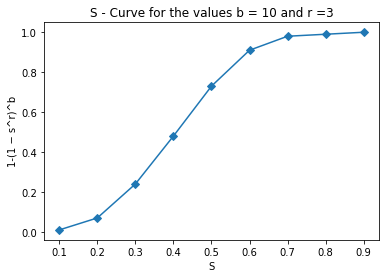

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
table = [['s', '1-(1 − s^r)^b'], ['0.1', '0.01'], ['0.2', '0.07'], ['0.3', '0.24'], ['0.4', '0.48'], ['0.5', '0.73'], ['0.6', '0.91'], ['0.7', '0.98'], ['0.8', '0.99'], ['0.9', '1.00']]
print("Computation Table for the S-Curve with values b = 10 and r =3:")
print(tabulate(table))
print()
# Dataset derived using the above formula with values b = 10 and r =3
s = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ])
y = np.array([ 0.01, 0.07, 0.24, 0.48, 0.73, 0.91, 0.98, 0.99, 1.00 ])
print("Below is the graph plotted for the above table:")
# Plotting the S-Curve for above dataset
plt.plot(s, y, marker='D')
plt.title("S - Curve for the values b = 10 and r =3")
plt.xlabel("S")
plt.ylabel("1-(1 − s^r)^b")
plt.show()

Computation Table for the S-Curve with values b = 20 and r = 6:
---  -------------
s    1-(1 − s^r)^b
0.1  0.000
0.2  0.001
0.3  0.014
0.4  0.078
0.5  0.270
0.6  0.615
0.7  0.918
0.8  0.997
0.9  1.000
---  -------------

Below is the graph plotted for the above table:


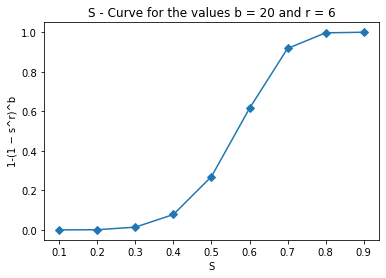

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
table = [['s', '1-(1 − s^r)^b'], ['0.1', '0.000'], ['0.2', '0.001'], ['0.3', '0.014'], ['0.4', '0.078'], ['0.5', '0.270'], ['0.6', '0.615'], ['0.7', '0.918'], ['0.8', '0.997'], ['0.9', '1.000']]
print("Computation Table for the S-Curve with values b = 20 and r = 6:")
print(tabulate(table))
print()
# Dataset derived using the above formula with values b = 20 and r = 6
s = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ])
y = np.array([ 0.000, 0.001, 0.014, 0.078, 0.270, 0.615, 0.918, 0.997, 1.000 ])
print("Below is the graph plotted for the above table:")
# Plotting the S-Curve for above dataset
plt.plot(s, y, marker='D')
plt.title("S - Curve for the values b = 20 and r = 6")
plt.xlabel("S")
plt.ylabel("1-(1 − s^r)^b")
plt.show()

Computation Table for the S-Curve with values b = 50 and r = 5:
---  -------------
s    1-(1 − s^r)^b
0.1  0.0005
0.2  0.0159
0.3  0.1145
0.4  0.4023
0.5  0.7956
0.6  0.9825
0.7  0.9999
0.8  1.0000
0.9  1.000
---  -------------

Below is the graph plotted for the above table:


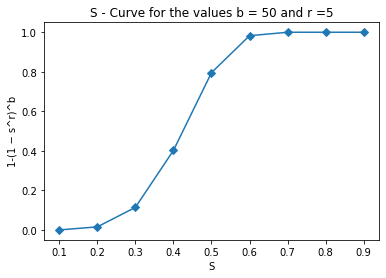

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
table = [['s', '1-(1 − s^r)^b'], ['0.1', '0.0005'], ['0.2', '0.0159'], ['0.3', '0.1145'], ['0.4', '0.4023'], ['0.5', '0.7956'], ['0.6', '0.9825'], ['0.7', '0.9999'], ['0.8', '1.0000'], ['0.9', '1.000']]
print("Computation Table for the S-Curve with values b = 50 and r = 5:")
print(tabulate(table))
print()
# Dataset derived using the above formula with values b = 50 and r = 5
s = np.array([ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ])
y = np.array([ 0.0005, 0.0159, 0.1145, 0.4023, 0.7956, 0.9825, 0.9999, 1.0000, 1.0000 ])
print("Below is the graph plotted for the above table:")
# Plotting the S-Curve for above dataset
plt.plot(s, y, marker='D')
plt.title("S - Curve for the values b = 50 and r =5")
plt.xlabel("S")
plt.ylabel("1-(1 − s^r)^b")
plt.show()

### ***Exercise 3.4.2 (Page 96)***

In [28]:
import matplotlib.pyplot as plt
print("The task is to compute the threshold for the formula 1-(1 − s^r)^b by equating it to 1/2")
print("Threshold can be defined as the value of similarity 's' on which the probability of becoming a candidate key is 0.5 for the functions b and r")
print()
print("Case A")
print("Computation of threshold for the values b = 10 and r = 3")
print("Given Formula --> 1-(1 − s^r)^b = 0.5")
print("substituting the above values in the formula:")
print("Formula = 1-(1-s^3)^10 = 0.5")
print("        => 0.5 = (1-s^3)^10")
print("        => s^3 = 1 - 0.9330")
print("s = 0.4098")
print("Hence the Threshold for the case is 0.4098")
print()
print("Case B")
print("Computation of threshold for the values s = 0.5, b = 20 and r = 6")
print("Given Formula --> 1-(1 − s^r)^b = 0.5")
print("substituting the above values in the formula:")
print("Formula = 1-(1-s^6)^20 = 0.5")
print("        => 0.5 = (1-s^6)^20")
print("        => s^6 = 1 - 0.965")
print("s = 0.5720")
print("Hence the Threshold for the case is 0.5720")
plt.show()
print()
print("Case C")
print("Computation of threshold for the values s = 0.5, b = 50 and r = 5")
print("Given Formula --> 1-(1 − s^r)^b = 0.5")
print("substituting the above values in the formula:")
print("Formula = 1-(1-s^5)^50 = 0.5")
print("        => 0.5 = (1-s^5)^50")
print("        => s^5 = 1 - 0.986")
print("s = 0.4258")
print("Hence the Threshold for the case is 0.4258")
print()
print("Now comapring the above cases with corresponding values of (1/b)^(1/r):")
table = [[' ', '1-(1 − s^r)^b', '(1/b)^(1/r)'], ['for b = 10 and r = 3', '0.4098', '0.4645'], ['for b = 20 and r = 6', '0.5720', '0.6082'], ['for b = 50 and r = 5', '0.4258', '0.4573']]
print("Computation Table for the S-Curve with values b = 50 and r = 5:")
print(tabulate(table))
print()
print("NOTE: From the above table we can say that the threshold values obtained are almost same to that of the (1/b)^(1/r) value")

The task is to compute the threshold for the formula 1-(1 − s^r)^b by equating it to 1/2
Threshold can be defined as the value of similarity 's' on which the probability of becoming a candidate key is 0.5 for the functions b and r

Case A
Computation of threshold for the values b = 10 and r = 3
Given Formula --> 1-(1 − s^r)^b = 0.5
substituting the above values in the formula:
Formula = 1-(1-s^3)^10 = 0.5
        => 0.5 = (1-s^3)^10
        => s^3 = 1 - 0.9330
s = 0.4098
Hence the Threshold for the case is 0.4098

Case B
Computation of threshold for the values s = 0.5, b = 20 and r = 6
Given Formula --> 1-(1 − s^r)^b = 0.5
substituting the above values in the formula:
Formula = 1-(1-s^6)^20 = 0.5
        => 0.5 = (1-s^6)^20
        => s^6 = 1 - 0.965
s = 0.5720
Hence the Threshold for the case is 0.5720

Case C
Computation of threshold for the values s = 0.5, b = 50 and r = 5
Given Formula --> 1-(1 − s^r)^b = 0.5
substituting the above values in the formula:
Formula = 1-(1-s^5)^50 = 0.